In [99]:
# patchfiy & label handling
#----------------------------------------------
import torch
import swin
import upper_net_mmseg
import torch.nn as nn 
import models
from tensorflow.keras.utils import to_categorical
from glob import glob
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
from patchify import patchify
import matplotlib.pyplot as plt
import cv2

In [100]:
img_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/DOTA_dataset/dota1_origin/train/images"
mask_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Data/isaid/TrainData/train/Semantic_masks/images/images"

imgs_list = glob(os.path.join(img_path,"*.png"))
mask_list = glob(os.path.join(mask_path,"*.png"))

imgs_list = sorted(imgs_list)
mask_list = sorted(mask_list)

In [101]:
len(imgs_list) == len(mask_list)

True

In [102]:
imgs_list[0].split("/")[-1].replace(".png","")

'P0000'

In [103]:
#---------------
# Patchify Images 

patch_size = 1024
cnt = 0
 
#--------------
image_dataset = []
image_dataset_name = [] 
for i, image_name in enumerate(tqdm(imgs_list)):
    image = cv2.imread(image_name, cv2.IMREAD_COLOR)
    image = np.asarray(image)
    
    height_ = image.shape[0]
    width_  = image.shape[1]

    # small images < patch_size
    if height_ < patch_size and width_ < patch_size:
        image = np.pad(image, [[0,patch_size-height_], [0,patch_size-width_],[0,0]], mode='constant' )
    elif height_ < patch_size and width_ > patch_size:
        image = np.pad(image, [[0,patch_size-height_], [0,0],[0,0]], mode='constant' )
    elif height_ > patch_size and width_ < patch_size:
        image = np.pad(image, [[0,0], [0,patch_size-width_],[0,0]], mode='constant' )
        
    height_ = image.shape[0]
    width_  = image.shape[1]

    SIZE_X = ( width_ //patch_size)*patch_size
    SIZE_Y = ( height_ //patch_size)*patch_size
 
    image = image[:SIZE_Y,:SIZE_X,:].copy()
    #print(i)
    patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
    #print(i)
    cnt +=1 
    # 
    
    prefix_img = imgs_list[i].split("/")[-1].replace(".png","")
    
    for j in range(patches_img.shape[0]):
        for k in range(patches_img.shape[1]):
            single_patch_img = patches_img[j,k,0,:,:]
            image_dataset.append(single_patch_img)
            file_name = prefix_img + f"_{j}_{k}.png"
            image_dataset_name.append(file_name)          

100%|██████████| 1411/1411 [02:31<00:00,  9.32it/s]


In [104]:
len(image_dataset) == len(image_dataset_name)

True

In [113]:
#---------------
# Save Patchify
root_path = f"/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/04.{patch_size}_imgs"
for i,file_name in enumerate(image_dataset_name):
    tmp_ = os.path.join(root_path,file_name )
    print(tmp_)
    cv2.imwrite(tmp_ ,image_dataset[i] )

/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/04.1024_imgs/P0000_0_0.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/04.1024_imgs/P0000_0_1.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/04.1024_imgs/P0000_0_2.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/04.1024_imgs/P0000_1_0.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/04.1024_imgs/P0000_1_1.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/04.1024_imgs/P0000_1_2.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/04.1024_imgs/P0000_2_0.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/04.1024_imgs/P0000_2_1.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/04.1024_imgs/P0000_2_2.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/04.1024_imgs/P0000_3_0.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/

In [106]:
mask_list[0]

'/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Data/isaid/TrainData/train/Semantic_masks/images/images/P0000_instance_color_RGB.png'

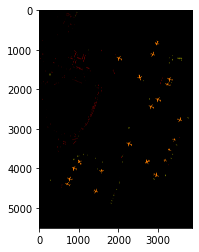

In [107]:
plt.imshow(cv2.imread(mask_list[0]))

In [109]:
#---------------
# Patchify labels 

patch_size = 1024
cnt = 0
 
#--------------
mask_dataset = []
mask_dataset_name = [] 

for i, image_name in enumerate(tqdm(mask_list)):
    image = cv2.imread(image_name, cv2.COLOR_BGR2RGB)
    image = np.asarray(image)
    
    height_ = image.shape[0]
    width_  = image.shape[1]

    # small images < patch_size
    if height_ < patch_size and width_ < patch_size:
        image = np.pad(image, [[0,patch_size-height_], [0,patch_size-width_],[0,0]], mode='constant' )
    elif height_ < patch_size and width_ > patch_size:
        image = np.pad(image, [[0,patch_size-height_], [0,0],[0,0]], mode='constant' )
    elif height_ > patch_size and width_ < patch_size:
        image = np.pad(image, [[0,0], [0,patch_size-width_],[0,0]], mode='constant' )
        
    height_ = image.shape[0]
    width_  = image.shape[1]

    SIZE_X = ( width_ //patch_size)*patch_size
    SIZE_Y = ( height_ //patch_size)*patch_size
 
    image = image[:SIZE_Y,:SIZE_X,:].copy()
    #print(i)
    patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
    #print(i)
    cnt +=1 
    # 
    
    prefix_img = mask_list[i].split("/")[-1].replace(".png","")
    
    for j in range(patches_img.shape[0]):
        for k in range(patches_img.shape[1]):
            single_patch_img = patches_img[j,k,0,:,:]
            mask_dataset.append(single_patch_img)
            file_name = prefix_img + f"_{j}_{k}.png"
            mask_dataset_name.append(file_name)          

100%|██████████| 1411/1411 [01:28<00:00, 15.91it/s]


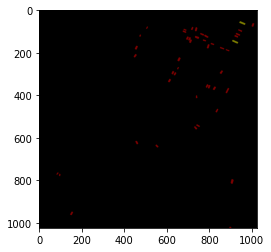

In [110]:
plt.imshow(mask_dataset[0])

In [112]:
#---------------
# Save Patchify
root_path = f"/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/05.{patch_size}_masks"
for i,file_name in enumerate(mask_dataset_name):
    tmp_ = os.path.join(root_path,file_name )
    print(tmp_)
    cv2.imwrite(tmp_ ,mask_dataset[i] )

/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/05.1024_masks/P0000_instance_color_RGB_0_0.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/05.1024_masks/P0000_instance_color_RGB_0_1.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/05.1024_masks/P0000_instance_color_RGB_0_2.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/05.1024_masks/P0000_instance_color_RGB_1_0.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/05.1024_masks/P0000_instance_color_RGB_1_1.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/05.1024_masks/P0000_instance_color_RGB_1_2.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/05.1024_masks/P0000_instance_color_RGB_2_0.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/05.1024_masks/P0000_instance_color_RGB_2_1.png
/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/05.

In [87]:
len(os.listdir("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/01.512_imgs")) == len(os.listdir("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/02.512_masks"))

True

In [88]:

len(os.listdir("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/01.512_imgs"))

29522

In [89]:
len(os.listdir("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/02.512_masks"))

29522